In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import string
import nltk
import torch
import pysentiment2 as ps
import tensorflow as tf
import xgboost as xgb
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Activation

In [2]:
#Reading the dataset
news = pd.read_csv('DJIA_Combined.csv')
news

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [3]:
#Finding if there are any missing values in the dataset
news.isna().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

In [4]:
#Droping rows with missing values
news = news.dropna()
news

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [5]:
news['Combined'] = news[['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25']].apply(lambda x: ' '.join(x), axis=1)
news = news.drop(columns=['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25'])
news

C:\Users\hp\AppData\Local\Temp\ipykernel_16464\973735039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news['Combined'] = news[['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25']].apply(lambda x: ' '.join(x), axis=1)


,Date,Combined
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,b'Why wont America and Nato help us? If they w...
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,b'All the experts admit that we should legalis...
...,...,...
1984,2016-06-27,Barclays and RBS shares suspended from trading...
1985,2016-06-28,"2,500 Scientists To Australia: If You Want To ..."
1986,2016-06-29,Explosion At Airport In Istanbul Yemeni former...
1987,2016-06-30,Jamaica proposes marijuana dispensers for tour...


In [6]:
#Finding if there are any duplicate rows in the combined dataset
duplicate = news.duplicated(subset = ['Date', 'Combined'])
duplicated_rows = news[duplicate]
duplicated_rows

,Date,Combined


In [7]:
news.to_csv('DJIA_bert.csv')

# Text Preprocessing and Sentiment Analysis

In [8]:
#Converting into lowercase
news['headline_lower']= news['Combined'].apply(lambda x: x.lower())

In [9]:
#Removing punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

news['headline_punctuation'] = news['headline_lower'].apply(remove_punctuation)

In [10]:
#Tokenizing data
news['headline_tokenized'] = news['headline_punctuation'].apply(nltk.word_tokenize)

In [11]:
#Removing stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

news['headline_without_stopwords'] = news['headline_tokenized'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#Lemmatizing data
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

news['headline_lemmatized']=news['headline_without_stopwords'].apply(lambda x:lemmatizer(x))

In [13]:
#Combining the preprocessed text
news['headline_preprocessed'] = news['headline_lemmatized'].apply(lambda x:' '.join(x))

In [14]:
news

,Date,Combined,headline_lower,headline_punctuation,headline_tokenized,headline_without_stopwords,headline_lemmatized,headline_preprocessed
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...","b""georgia 'downs two russian warplanes' as cou...",bgeorgia downs two russian warplanes as countr...,"[bgeorgia, downs, two, russian, warplanes, as,...","[bgeorgia, downs, two, russian, warplanes, cou...","[bgeorgia, down, two, russian, warplane, count...",bgeorgia down two russian warplane country mov...
1,2008-08-11,b'Why wont America and Nato help us? If they w...,b'why wont america and nato help us? if they w...,bwhy wont america and nato help us if they won...,"[bwhy, wont, america, and, nato, help, us, if,...","[bwhy, wont, america, nato, help, us, wont, he...","[bwhy, wont, america, nato, help, u, wont, hel...",bwhy wont america nato help u wont help u help...
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...,b'remember that adorable 9-year-old who sang a...,bremember that adorable 9yearold who sang at t...,"[bremember, that, adorable, 9yearold, who, san...","[bremember, adorable, 9yearold, sang, opening,...","[bremember, adorable, 9yearold, sang, opening,...",bremember adorable 9yearold sang opening cerem...
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...,b' u.s. refuses israel weapons to attack iran:...,b us refuses israel weapons to attack iran rep...,"[b, us, refuses, israel, weapons, to, attack, ...","[b, us, refuses, israel, weapons, attack, iran...","[b, u, refuse, israel, weapon, attack, iran, r...",b u refuse israel weapon attack iran report bw...
4,2008-08-14,b'All the experts admit that we should legalis...,b'all the experts admit that we should legalis...,ball the experts admit that we should legalise...,"[ball, the, experts, admit, that, we, should, ...","[ball, experts, admit, legalise, drugs, bwar, ...","[ball, expert, admit, legalise, drug, bwar, so...",ball expert admit legalise drug bwar south ose...
...,...,...,...,...,...,...,...,...
1984,2016-06-27,Barclays and RBS shares suspended from trading...,barclays and rbs shares suspended from trading...,barclays and rbs shares suspended from trading...,"[barclays, and, rbs, shares, suspended, from, ...","[barclays, rbs, shares, suspended, trading, ta...","[barclays, rb, share, suspended, trading, tank...",barclays rb share suspended trading tanking 8 ...
1985,2016-06-28,"2,500 Scientists To Australia: If You Want To ...","2,500 scientists to australia: if you want to ...",2500 scientists to australia if you want to sa...,"[2500, scientists, to, australia, if, you, wan...","[2500, scientists, australia, want, save, grea...","[2500, scientist, australia, want, save, great...",2500 scientist australia want save great barri...
1986,2016-06-29,Explosion At Airport In Istanbul Yemeni former...,explosion at airport in istanbul yemeni former...,explosion at airport in istanbul yemeni former...,"[explosion, at, airport, in, istanbul, yemeni,...","[explosion, airport, istanbul, yemeni, former,...","[explosion, airport, istanbul, yemeni, former,...",explosion airport istanbul yemeni former presi...
1987,2016-06-30,Jamaica proposes marijuana dispensers for tour...,jamaica proposes marijuana dispensers for tour...,jamaica proposes marijuana dispensers for tour...,"[jamaica, proposes, marijuana, dispensers, for...","[jamaica, proposes, marijuana, dispensers, tou...","[jamaica, proposes, marijuana, dispenser, tour...",jamaica proposes marijuana dispenser tourist a...


In [15]:
#Dropping irrelevant columns
columns_to_drop = ['Combined', 'headline_lower', 'headline_punctuation', 'headline_tokenized', 'headline_without_stopwords']
Final = news.drop(columns_to_drop, axis=1)

In [16]:
Final

,Date,headline_lemmatized,headline_preprocessed
0,2008-08-08,"[bgeorgia, down, two, russian, warplane, count...",bgeorgia down two russian warplane country mov...
1,2008-08-11,"[bwhy, wont, america, nato, help, u, wont, hel...",bwhy wont america nato help u wont help u help...
2,2008-08-12,"[bremember, adorable, 9yearold, sang, opening,...",bremember adorable 9yearold sang opening cerem...
3,2008-08-13,"[b, u, refuse, israel, weapon, attack, iran, r...",b u refuse israel weapon attack iran report bw...
4,2008-08-14,"[ball, expert, admit, legalise, drug, bwar, so...",ball expert admit legalise drug bwar south ose...
...,...,...,...
1984,2016-06-27,"[barclays, rb, share, suspended, trading, tank...",barclays rb share suspended trading tanking 8 ...
1985,2016-06-28,"[2500, scientist, australia, want, save, great...",2500 scientist australia want save great barri...
1986,2016-06-29,"[explosion, airport, istanbul, yemeni, former,...",explosion airport istanbul yemeni former presi...
1987,2016-06-30,"[jamaica, proposes, marijuana, dispenser, tour...",jamaica proposes marijuana dispenser tourist a...


# BERT

In [17]:
model_name = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def bert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    sentiment_scores = torch.softmax(logits, dim=1).tolist()[0]
    return sentiment_scores

Final['BERT_Sentiment'] = Final['headline_preprocessed'].apply(bert_sentiment)

Final['BERT_Positive'] = Final['BERT_Sentiment'].apply(lambda x: x[0])
Final['BERT_Negative'] = Final['BERT_Sentiment'].apply(lambda x: x[1])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# MiniLM

In [18]:
model_name = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def miniLM_sentiment(text, max_length=512):
    if len(text) > max_length:
        text = text[:max_length]

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    sentiment_scores = torch.softmax(logits, dim=1).tolist()[0]
    return sentiment_scores

max_text_length = 512

Final['MiniLM_Sentiment'] = Final['headline_preprocessed'].apply(lambda text: miniLM_sentiment(text, max_text_length))

Final['MiniLM_Positive'] = Final['MiniLM_Sentiment'].apply(lambda x: x[0])
Final['MiniLM_Negative'] = Final['MiniLM_Sentiment'].apply(lambda x: x[1])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Harvard

In [19]:
hiv4 = ps.HIV4()
def calculate_sentiment_scores(tokens):
    score = hiv4.get_score(tokens)
    return score

Final[['H_Positive', 'H_Negative', 'H_Aggregate']] = Final['headline_lemmatized'].apply(calculate_sentiment_scores).apply(lambda x: pd.Series([x['Positive'], x['Negative'], x['Polarity']]))

# Loughran and McDonald

In [20]:
lm = ps.LM()
def calculate_sentiment(tokens):
    score = lm.get_score(tokens)
    return score

Final[['LM_Positive', 'LM_Negative', 'LM_Aggregate']] = Final['headline_lemmatized'].apply(calculate_sentiment).apply(lambda x: pd.Series([x['Positive'], x['Negative'], x['Polarity']]))

# VADER

In [21]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
analyzer = SentimentIntensityAnalyzer()
Final['Sentiment_Score'] = Final['headline_preprocessed'].apply(lambda x: analyzer.polarity_scores(x))
Final['Positive_Score'] = Final['Sentiment_Score'].apply(lambda x: x['pos'])
Final['Negative_Score'] = Final['Sentiment_Score'].apply(lambda x: x['neg'])
Final['Neutral_Score'] = Final['Sentiment_Score'].apply(lambda x: x['neu'])
Final['Compound_Score'] = Final['Sentiment_Score'].apply(lambda x: x['compound'])

# TextBlob

In [23]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment

Final['Sentiment_TB'] = Final['headline_preprocessed'].apply(analyze_sentiment)
Final['Polarity'] = Final['Sentiment_TB'].apply(lambda x: x.polarity)
Final['Subjectivity'] = Final['Sentiment_TB'].apply(lambda x: x.subjectivity)

In [24]:
Final

,Date,headline_lemmatized,headline_preprocessed,BERT_Sentiment,BERT_Positive,BERT_Negative,MiniLM_Sentiment,MiniLM_Positive,MiniLM_Negative,H_Positive,...,LM_Negative,LM_Aggregate,Sentiment_Score,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Sentiment_TB,Polarity,Subjectivity
0,2008-08-08,"[bgeorgia, down, two, russian, warplane, count...",bgeorgia down two russian warplane country mov...,"[0.56648850440979, 0.4335114657878876]",0.566489,0.433511,"[0.4971490204334259, 0.5028510093688965]",0.497149,0.502851,10.0,...,5.0,-1.000000,"{'neg': 0.285, 'neu': 0.649, 'pos': 0.066, 'co...",0.066,0.285,0.649,-0.9972,"(-0.04936452436452436, 0.26476578976578974)",-0.049365,0.264766
1,2008-08-11,"[bwhy, wont, america, nato, help, u, wont, hel...",bwhy wont america nato help u wont help u help...,"[0.6228135228157043, 0.37718647718429565]",0.622814,0.377186,"[0.4967145323753357, 0.5032854676246643]",0.496715,0.503285,6.0,...,8.0,-0.600000,"{'neg': 0.273, 'neu': 0.635, 'pos': 0.092, 'co...",0.092,0.273,0.635,-0.9888,"(0.07986631016042779, 0.33426024955436723)",0.079866,0.334260
2,2008-08-12,"[bremember, adorable, 9yearold, sang, opening,...",bremember adorable 9yearold sang opening cerem...,"[0.5088671445846558, 0.49113285541534424]",0.508867,0.491133,"[0.49686646461486816, 0.5031334757804871]",0.496866,0.503133,10.0,...,2.0,-1.000000,"{'neg': 0.251, 'neu': 0.656, 'pos': 0.093, 'co...",0.093,0.251,0.656,-0.9931,"(-0.0363073593073593, 0.5312294372294373)",-0.036307,0.531229
3,2008-08-13,"[b, u, refuse, israel, weapon, attack, iran, r...",b u refuse israel weapon attack iran report bw...,"[0.5782263278961182, 0.42177364230155945]",0.578226,0.421774,"[0.496828556060791, 0.5031713843345642]",0.496829,0.503171,13.0,...,4.0,-0.600000,"{'neg': 0.197, 'neu': 0.709, 'pos': 0.093, 'co...",0.093,0.197,0.709,-0.9758,"(0.016060985797827904, 0.3703007518796992)",0.016061,0.370301
4,2008-08-14,"[ball, expert, admit, legalise, drug, bwar, so...",ball expert admit legalise drug bwar south ose...,"[0.5903496146202087, 0.40965038537979126]",0.590350,0.409650,"[0.496907114982605, 0.5030929446220398]",0.496907,0.503093,11.0,...,3.0,-1.000000,"{'neg': 0.227, 'neu': 0.652, 'pos': 0.121, 'co...",0.121,0.227,0.652,-0.9805,"(0.024498418248418252, 0.3283882783882784)",0.024498,0.328388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,"[barclays, rb, share, suspended, trading, tank...",barclays rb share suspended trading tanking 8 ...,"[0.618050217628479, 0.3819497227668762]",0.618050,0.381950,"[0.4959718883037567, 0.5040281414985657]",0.495972,0.504028,7.0,...,4.0,-0.600000,"{'neg': 0.219, 'neu': 0.664, 'pos': 0.117, 'co...",0.117,0.219,0.664,-0.9839,"(-0.0060984848484848435, 0.34939393939393937)",-0.006098,0.349394
1985,2016-06-28,"[2500, scientist, australia, want, save, great...",2500 scientist australia want save great barri...,"[0.6159130930900574, 0.38408684730529785]",0.615913,0.384087,"[0.49698325991630554, 0.5030168294906616]",0.496983,0.503017,20.0,...,11.0,-0.692308,"{'neg': 0.172, 'neu': 0.685, 'pos': 0.143, 'co...",0.143,0.172,0.685,-0.9424,"(0.03946526957890595, 0.329909484454939)",0.039465,0.329909
1986,2016-06-29,"[explosion, airport, istanbul, yemeni, former,...",explosion airport istanbul yemeni former presi...,"[0.578757107257843, 0.421242892742157]",0.578757,0.421243,"[0.4970179498195648, 0.5029820799827576]",0.497018,0.502982,6.0,...,6.0,-0.714286,"{'neg': 0.26, 'neu': 0.617, 'pos': 0.123, 'com...",0.123,0.260,0.617,-0.9943,"(0.050124875124875116, 0.3871073371073371)",0.050125,0.387107
1987,2016-06-30,"[jamaica, proposes, marijuana, dispenser, tour...",jamaica proposes marijuana dispenser tourist a...,"[0.5853302478790283, 0.4146696925163269]",0.585330,0.414670,"[0.49703752994537354, 0.5029624700546265]",0.497038,0.502962,11.0,...,9.0,-0.636364,"{'neg': 0.297, 'neu': 0.616, 'pos': 0.087, 'co...",0.087,0.297,0.616,-0.9982,"(0.018968253968253967, 0.3775396825396827)",0.018968,0.37754

In [25]:
#Dropping irrelevant columns
columns_to_drop1 = ['headline_preprocessed', 'headline_lemmatized', 'Sentiment_Score', 'Sentiment_TB', 'BERT_Sentiment', 'MiniLM_Sentiment']
Final = Final.drop(columns_to_drop1, axis=1)

In [26]:
#Converting the date to datetime format
Final['Date'] = pd.to_datetime(Final['Date'])

In [29]:
Final

,Date,BERT_Positive,BERT_Negative,MiniLM_Positive,MiniLM_Negative,H_Positive,H_Negative,H_Aggregate,LM_Positive,LM_Negative,LM_Aggregate,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Polarity,Subjectivity
0,2008-08-08,0.566489,0.433511,0.497149,0.502851,10.0,16.0,-0.230769,0.0,5.0,-1.000000,0.066,0.285,0.649,-0.9972,-0.049365,0.264766
1,2008-08-11,0.622814,0.377186,0.496715,0.503285,6.0,10.0,-0.250000,2.0,8.0,-0.600000,0.092,0.273,0.635,-0.9888,0.079866,0.334260
2,2008-08-12,0.508867,0.491133,0.496866,0.503133,10.0,19.0,-0.310345,0.0,2.0,-1.000000,0.093,0.251,0.656,-0.9931,-0.036307,0.531229
3,2008-08-13,0.578226,0.421774,0.496829,0.503171,13.0,12.0,0.040000,1.0,4.0,-0.600000,0.093,0.197,0.709,-0.9758,0.016061,0.370301
4,2008-08-14,0.590350,0.409650,0.496907,0.503093,11.0,13.0,-0.083333,0.0,3.0,-1.000000,0.121,0.227,0.652,-0.9805,0.024498,0.328388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,0.618050,0.381950,0.495972,0.504028,7.0,12.0,-0.263158,1.0,4.0,-0.600000,0.117,0.219,0.664,-0.9839,-0.006098,0.349394
1985,2016-06-28,0.615913,0.384087,0.496983,0.503017,20.0,15.0,0.142857,2.0,11.0,-0.692308,0.143,0.172,0.685,-0.9424,0.039465,0.329909
1986,2016-06-29,0.578757,0.421243,0.497018,0.502982,6.0,14.0,-0.400000,1.0,6.0,-0.714286,0.123,0.260,0.617,-0.9943,0.050125,0.387107
1987,2016-06-30,0.585330,0.414670,0.497038,0.502962,11.0,25.0,-0.388889,2.0,9.0,-0.636364,0.087,0.297,0.616,-0.9982,0.018968,0.377540


In [30]:
Final.to_csv('DJIA_Sentiment.csv')

# Stock Data 

In [31]:
#Reading the dataset
stock = pd.read_csv('DJIA_stock.csv')
stock

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234
...,...,...,...,...,...,...,...
1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688
1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609


In [32]:
#Converting the date to datetime format
stock['Date'] = pd.to_datetime(stock['Date'])

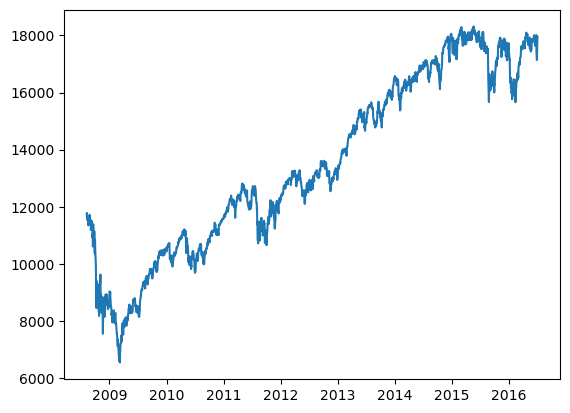

<Figure size 2000x5000 with 0 Axes>

In [33]:
plt.plot(stock['Date'], stock['Close'])
plt.figure(figsize=(20,50))
plt.show()

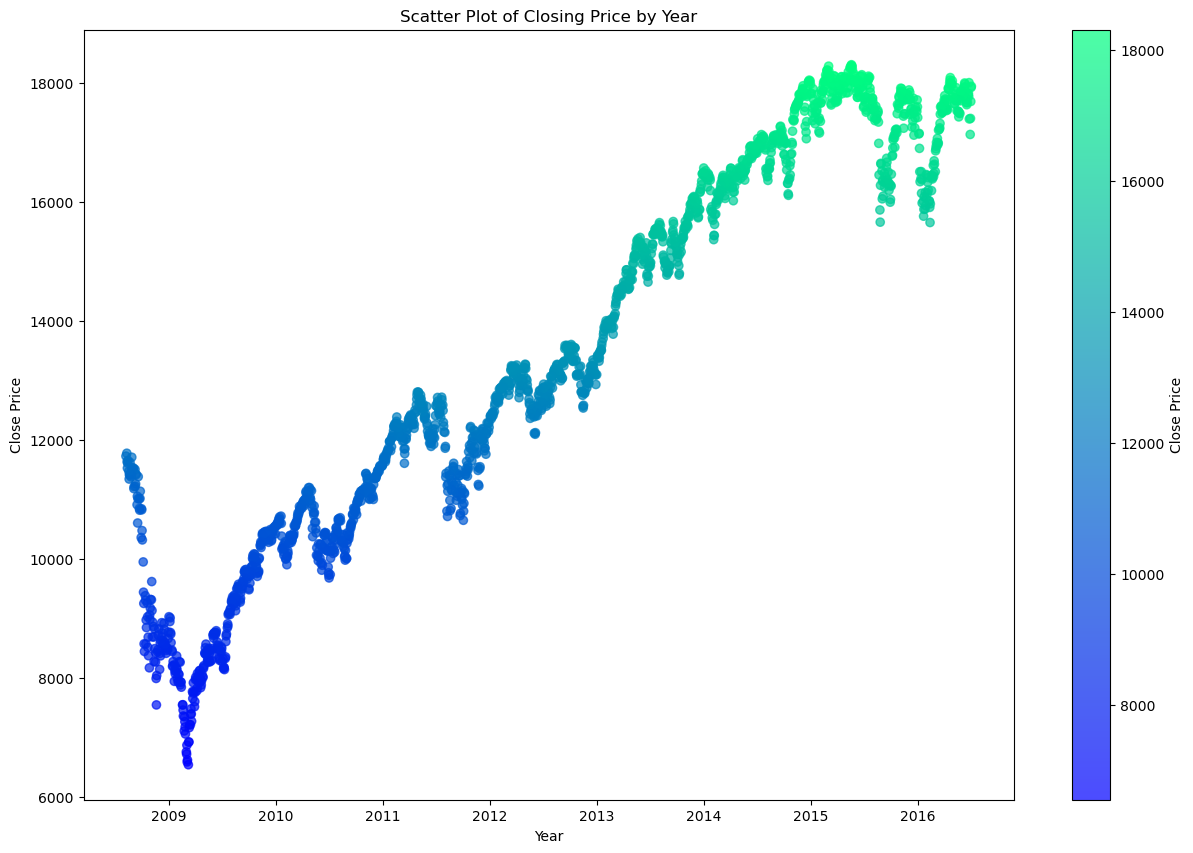

In [34]:
close = stock['Close']
date = stock['Date']
plt.figure(figsize=(15,10))
plt. scatter(date, close, c=close, cmap = 'winter', alpha = 0.7)
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.colorbar(label='Close Price')
plt.title('Scatter Plot of Closing Price by Year')
plt.show()

In [35]:
#Normalizing the stock data
columns_to_normalize = ['Open', 'Close', 'High', 'Low', 'Volume', 'Adj Close']
selected_columns = stock[columns_to_normalize]

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(selected_columns)
normalized_stock = pd.DataFrame(normalized_columns, columns=columns_to_normalize)

stock[columns_to_normalize] = normalized_stock
stock

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,0.966790,0.970024,0.969867,0.969145,0.110651,0.969145
1,2016-06-30,0.948819,0.963859,0.952488,0.967498,0.186974,0.967498
2,2016-06-29,0.927002,0.944437,0.930817,0.947497,0.146990,0.947497
3,2016-06-28,0.904440,0.919115,0.908321,0.923277,0.155707,0.923277
4,2016-06-27,0.918436,0.914433,0.897524,0.900373,0.195541,0.900373
...,...,...,...,...,...,...,...
1984,2008-08-14,0.423610,0.430233,0.422020,0.430832,0.227123,0.430832
1985,2008-08-13,0.432170,0.422975,0.422228,0.423779,0.261271,0.423779
1986,2008-08-12,0.444822,0.435737,0.434783,0.433087,0.247828,0.433087
1987,2008-08-11,0.440401,0.443018,0.441053,0.444976,0.262232,0.444976


In [36]:
#Merging stock and news data
merged_SH = pd.merge(stock, Final, on="Date", how="outer")
merged_SH

,Date,Open,High,Low,Close,Volume,Adj Close,BERT_Positive,BERT_Negative,MiniLM_Positive,...,H_Aggregate,LM_Positive,LM_Negative,LM_Aggregate,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Polarity,Subjectivity
0,2016-07-01,0.966790,0.970024,0.969867,0.969145,0.110651,0.969145,0.588598,0.411402,0.496734,...,-0.315789,2.0,10.0,-0.666667,0.068,0.302,0.631,-0.9987,-0.006564,0.316409
1,2016-06-30,0.948819,0.963859,0.952488,0.967498,0.186974,0.967498,0.585330,0.414670,0.497038,...,-0.388889,2.0,9.0,-0.636364,0.087,0.297,0.616,-0.9982,0.018968,0.377540
2,2016-06-29,0.927002,0.944437,0.930817,0.947497,0.146990,0.947497,0.578757,0.421243,0.497018,...,-0.400000,1.0,6.0,-0.714286,0.123,0.260,0.617,-0.9943,0.050125,0.387107
3,2016-06-28,0.904440,0.919115,0.908321,0.923277,0.155707,0.923277,0.615913,0.384087,0.496983,...,0.142857,2.0,11.0,-0.692308,0.143,0.172,0.685,-0.9424,0.039465,0.329909
4,2016-06-27,0.918436,0.914433,0.897524,0.900373,0.195541,0.900373,0.618050,0.381950,0.495972,...,-0.263158,1.0,4.0,-0.600000,0.117,0.219,0.664,-0.9839,-0.006098,0.349394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2008-08-14,0.423610,0.430233,0.422020,0.430832,0.227123,0.430832,0.590350,0.409650,0.496907,...,-0.083333,0.0,3.0,-1.000000,0.121,0.227,0.652,-0.9805,0.024498,0.328388
1985,2008-08-13,0.432170,0.422975,0.422228,0.423779,0.261271,0.423779,0.578226,0.421774,0.496829,...,0.040000,1.0,4.0,-0.600000,0.093,0.197,0.709,-0.9758,0.016061,0.370301
1986,2008-08-12,0.444822,0.435737,0.434783,0.433087,0.247828,0.433087,0.508867,0.491133,0.496866,...,-0.310345,0.0,2.0,-1.000000,0.093,0.251,0.656,-0.9931,-0.036307,0.531229
1987,2008-08-11,0.440401,0.443018,0.441053,0.444976,0.262232,0.444976,0.622814,0.377186,0.496715,...,-0.250000,2.0,8.0,-0.600000,0.092,0.273,0.635,-0.9888,0.079866,0.334260


In [37]:
merged_SH.to_csv('DJIA_merged.csv')